<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-OctavioGMoran/blob/main/TecMty_kmeans_target_1213977.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Actividad Semanal -- 7 Regresiones y K means**

Materia:
Ciencia y analítica de datos

Fecha: 09/11/2022

Octavio Alberto García Morán - A01213977

---

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [5]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from pandas.core.internals.concat import concat_arrays
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic

Importa la base de datos

In [7]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [8]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [10]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

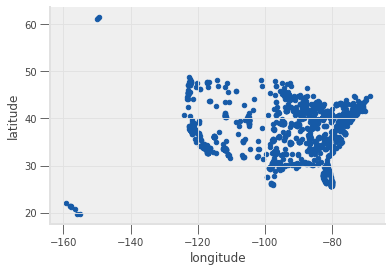

In [11]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [12]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [13]:
!pip install --upgrade geopandas
!pip install qeds pyLDAvis gensim folium xgboost descartes pyarrow graphviz --upgrade

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [15]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [16]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [17]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

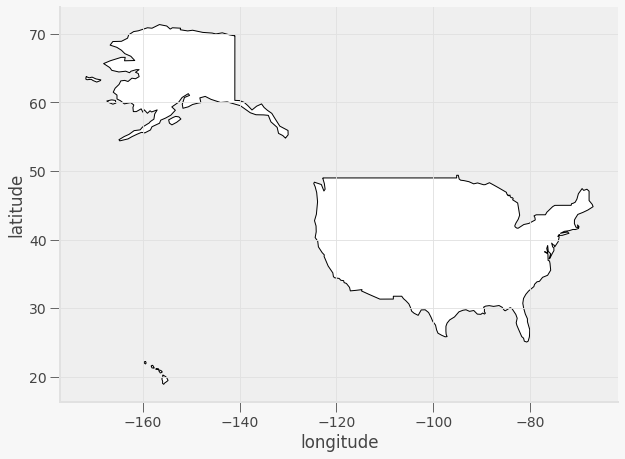

In [18]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

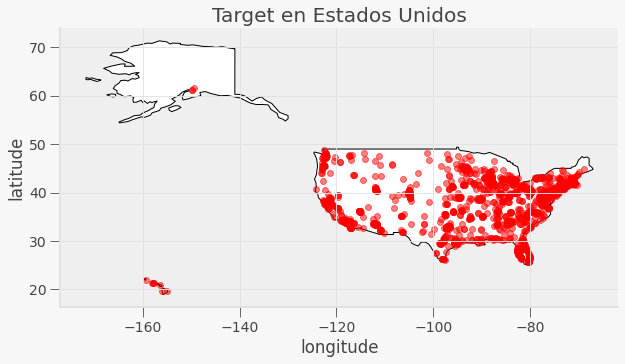

In [19]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

# **Gráfico de Elbow**

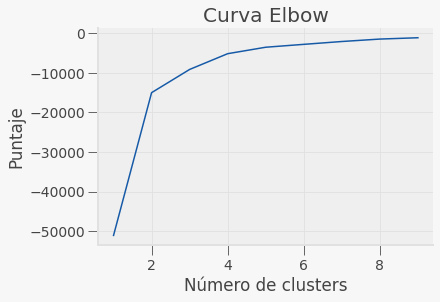

In [21]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = latlong[['latitude']]
X_axis = latlong[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Número de clusters')
plt.ylabel('Puntaje')
plt.title('Curva Elbow')
plt.show()

**Tomando en cuenta la teoría de la gráfica de codo, en cuanto se da el quiebre importante en la gráfica se debe determinar el número de clusters, en este caso parecer que el número óptimo es de 3, pero se podría estirar un poco el número de clusters a 4.**

# **Ejercicio con 3 Clusters**

In [45]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(latlong[latlong.columns[0:2]])
labels = kmeans.labels_
labels

array([0, 0, 0, ..., 2, 0, 2], dtype=int32)

In [46]:
X = df[["longitude","latitude"]]

kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X) 

C = kmeans.cluster_centers_

C_DF = pd.DataFrame(C)
C_DF["Coordinates"] = list(zip(C_DF[0], C_DF[1])) 
C_DF["Coordinates"] = C_DF["Coordinates"].apply(Point)


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordinates") 
gdf_C

,0,1,Coordinates
0,-93.279950,37.987914,POINT (-93.27995 37.98791)
1,-118.624473,37.487342,POINT (-118.62447 37.48734)
2,-78.534390,37.782609,POINT (-78.53439 37.78261)


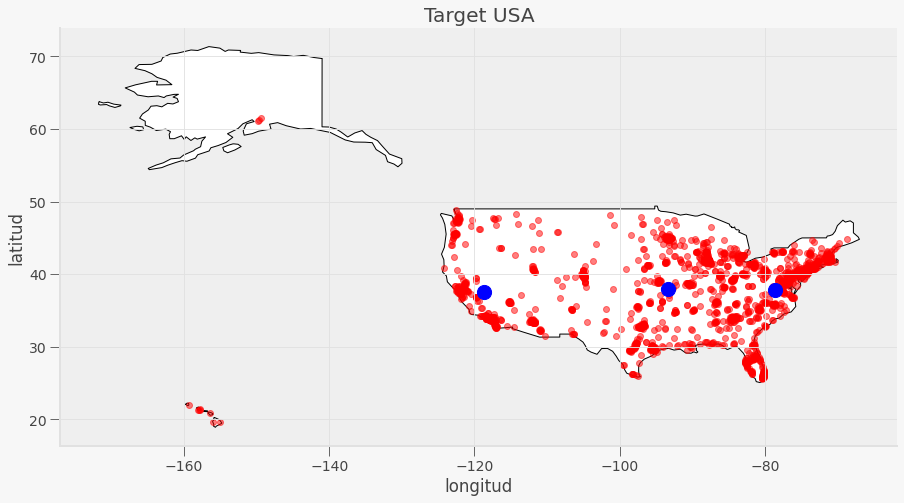

In [47]:
fig, gax = plt.subplots(figsize=(15,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='red', alpha = 0.5)
gdf_C.plot(ax=gax, color='blue', alpha = 1, markersize = 200)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Target USA')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

# **Ejercicio con 4 Clusters**

In [49]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(latlong[latlong.columns[0:3]])
labels = kmeans.labels_
labels

array([2, 2, 2, ..., 3, 3, 1], dtype=int32)

In [50]:
X = df[["longitude","latitude"]]

kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X) 

C = kmeans.cluster_centers_

C_DF = pd.DataFrame(C)
C_DF["Coordinates"] = list(zip(C_DF[0], C_DF[1])) 
C_DF["Coordinates"] = C_DF["Coordinates"].apply(Point)


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordinates") 
gdf_C

,0,1,Coordinates
0,-75.275533,40.332247,POINT (-75.27553 40.33225)
1,-119.146456,37.577577,POINT (-119.14646 37.57758)
2,-84.821801,36.561016,POINT (-84.82180 36.56102)
3,-96.988056,36.990483,POINT (-96.98806 36.99048)


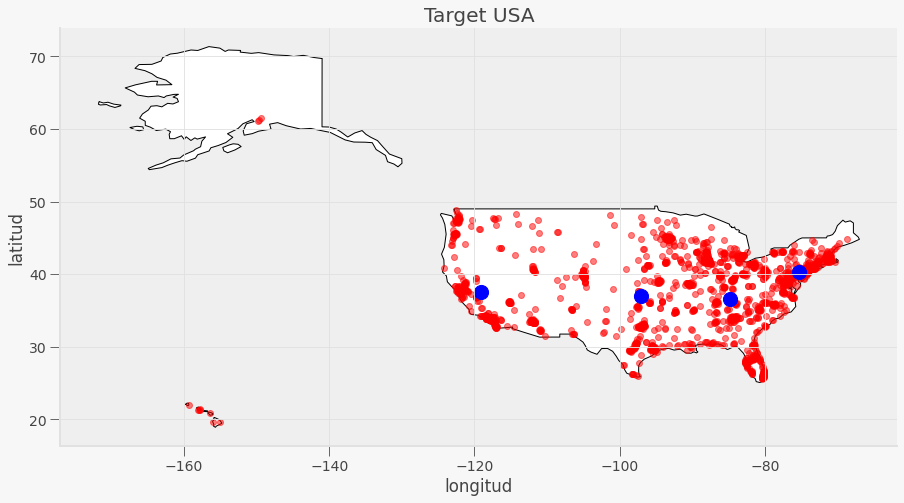

In [51]:
fig, gax = plt.subplots(figsize=(15,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='red', alpha = 0.5)
gdf_C.plot(ax=gax, color='blue', alpha = 1, markersize = 200)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Target USA')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

## **Tiendas que se van a surtir**

**tomando en cuenta 4 clusters, se atenderan a 1,839 tiendas con estas nuevas ubicaciones.**

In [52]:
latlong['kmeans'] = kmeans.labels_
latlong.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


2    615
0    454
3    401
1    369
Name: kmeans, dtype: int64

In [53]:
gdf_C

,0,1,Coordinates
0,-75.275533,40.332247,POINT (-75.27553 40.33225)
1,-119.146456,37.577577,POINT (-119.14646 37.57758)
2,-84.821801,36.561016,POINT (-84.82180 36.56102)
3,-96.988056,36.990483,POINT (-96.98806 36.99048)


## **Ciudades en las que se ubicará**

In [55]:
Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0]) 
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)
Location4 = str(gdf_C[1][3]) + ", " + str(gdf_C[0][3])
print(Location3)

40.33224701032967, -75.27553282527472
37.57757741219512, -119.14645561138212
36.561016371266234, -84.82180092435064
36.561016371266234, -84.82180092435064


In [59]:
geolocator = Nominatim(user_agent="my-application") #Inicializamos la libreria
Locations = [Location1, Location2, Location3, Location4] #Metemos las coordenadas obtenidas

for i in Locations:
  location = geolocator.reverse(i) #Reverse porque?, porque normal tu le metes el lugar y te da la direccion, pero si le volteas la tortilla, le metes la latitud, y te devuelve  la ciudad, 
  print('almacen localizado en ', location.address)

almacen localizado en  Diamond Street, Hilltown Township, Bucks County, Pennsylvania, 18962, United States
almacen localizado en  Mammoth Trail, Madera County, California, United States
almacen localizado en  John Muir Trail, Pickett County, Tennessee, United States
almacen localizado en  North Longwood Drive, Kay County, Oklahoma, United States


## **Distancia entre nuevos almacenes**

In [63]:

distancia1 = str(geodesic(Location1, Location2).miles)
print("\nDistancia entre almacenes 1 y 2 : ", distancia1, " millas \n") 
distancia2 = str(geodesic(Location2, Location3).miles)
print("Distancia entre almacenes 2 y 3 : ", distancia2, " millas \n")
distancia3 = str(geodesic(Location3, Location4).miles)
print("Distancia entre almacenes 3 y 4 : ", distancia3, " millas \n")



Distancia entre almacenes 1 y 2 :  2346.3893796007856  millas 

Distancia entre almacenes 2 y 3 :  1887.4531222784362  millas 

Distancia entre almacenes 3 y 4 :  675.0678386125368  millas 



# **Parte 2: visualización**

Con la investigación de diversas fuentes, pude concluir que existen diversas librerías que apoyan al análisis geoespacial de los datos. A continuación, hago mención de las 3 más relevantes:



1.   Arcpy: es un modulo que se apalanca de la tecnología de ArcGis, ésta permite realizar análisis y transformaciones de las variables geoespaciales, además de poder administrar los datos de manera ordenada y de poder realizar conversiones de la información.
2.   Geopandas: librería que se usó en la tarea para realizar mapas y ubicarlos en distintas capas para tener representaciones con información relevante.

3. OGR: permite "traducir" distintos formatos de información geoespacial para poder consumirlos y realizar más transformaciones con otras librerías.

Es de vital importancia poder representar los datos de manera geográfica, ya que no solamente se toman decisiones con modelos sofisticados, muchas veces el aspecto visual permite dejar datos mucho más en la mente de los tomadores de decisiones. Adicionalmente, no siempre los datos vienen en los mejores formatos y es necesario realizar muchas transformaciones para qu estos puedan ser consumidos, por eso estas librerías son tan útiles para los analistas de información.

